In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.layers import Flatten, Dense
from keras.api._v2.keras.optimizers import SGD
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler


In [7]:
df = pd.read_csv('ozone.csv')
training_data = df[['Temp', 'Ozone']]

# 이렇게 데이터를 가져온 후 당연히 데이터 전처리를 해야 해요!
# 1. 결측치 처리!
training_data = training_data.dropna(how='any')
# 2. 이상치 처리!
zscore_threshold = 1.8

outlier = training_data['Ozone'][np.abs(stats.zscore(training_data['Ozone'].values)) > zscore_threshold]

# print(outlier)

# 이상치를 제거한 결과를 얻어야 해요!
# 내가 가진 DataFrame에서 이상치를 제거하면 되요!
training_data = training_data.loc[np.isin(training_data['Ozone'],outlier, invert=True)]
display(training_data)

# 3. 정규화 진행(Normalization)
#    모든 feature에 대해 scale을 0과 1로 변경!
#    이렇게 해야 해요!
#    먼저 Temp에 대해 최대값, 최소값을 찾아요!
# print(np.max(training_data['Temp'].values)) # 97
# print(np.min(training_data['Temp'].values)) # 57
# scaled_data = (67 -  57) / (97 - 57)
# print(scaled_data)   # 0.25

# sklearn을 이용해서 정규화작업 쉽게 가능
scaled_x = MinMaxScaler()
scaled_t = MinMaxScaler()

scaled_x.fit(training_data['Temp'].values.reshape(-1,1))
scaled_t.fit(training_data['Ozone'].values.reshape(-1,1))

# Training Data Set 준비
x_data = scaled_x.transform(training_data['Temp'].values.reshape(-1,1))
t_data = scaled_t.transform(training_data['Ozone'].values.reshape(-1,1))

def numerical_derivative(f,x):

    # f : 미분하려고하는 다변수 함수
    # x : 모든 변수를 포함하는 ndarray  [1.0 2.0]
    # 리턴되는 결과는 [8.0 15.0]

    delta_x = 1e-4
    derivative_x = np.zeros_like(x)   #  [0.0 0.0]

    it = np.nditer(x, flags=['multi_index'])

    while not it.finished:

        idx = it.multi_index  # 현재의 index를 추출 => tuple형태로 리턴.

        tmp = x[idx]    # 현재 index의 값을 일단 잠시 보존해야해요!
                        # 밑에서 이 값을 변경해서 중앙차분 값을 계산해야 해요!
                        # 그런데 우리 편미분해야해요. 다음 변수 편미분할때
                        # 원래값으로 복원해야 편미분이 정상적으로 진행되기 때문에
                        # 이값을 잠시 보관했다가 원상태로 복구해야 해요!
        x[idx] = tmp + delta_x
        fx_plus_delta_x = f(x)  # f(x + delta_x)

        x[idx] = tmp - delta_x
        fx_minus_delta_x = f(x) # f(x - delta_x)

        derivative_x[idx] = (fx_plus_delta_x - fx_minus_delta_x) / (2 * delta_x)

        x[idx] = tmp

        it.iternext()

    return derivative_x
W = np.random.rand(1,1)
b = np.random.rand(1)

def loss_func(input_data):

    input_w = input_data[0]
    input_b = input_data[1]

    y = np.dot(x_data, input_w) + input_b

    return np.mean(np.power((t_data-y),2))

# 모델이 완성된 후 예측하는 함수를 하나 만들어요!
def predict(x):

    return np.dot(x, W) + b

learning_rate = 1e-4

for step in range(300000):

    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)

    W = W - derivative_result[0].reshape(-1,1)
    b = b - derivative_result[1]

    if step % 30000 == 0:
        print(f'W : {W}, b : {b}, loss : {loss_func(input_param)}')



,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


W : [[0.07370695]], b : [0.34560231], loss : 0.06409385340808445
W : [[0.26160128]], b : [0.2541104], loss : 0.04939963746113337
W : [[0.40344974]], b : [0.17865543], loss : 0.040745439721519665
W : [[0.51257158]], b : [0.1206059], loss : 0.03562377144940318
W : [[0.59651835]], b : [0.07594875], loss : 0.03259270066385227
W : [[0.66109809]], b : [0.04159427], loss : 0.030798873024323353
W : [[0.7107789]], b : [0.01516558], loss : 0.029737262185118702
W : [[0.74899804]], b : [-0.00516585], loss : 0.02910898689875246
W : [[0.77839979]], b : [-0.0208067], loss : 0.02873716530379354
W : [[0.80101839]], b : [-0.03283911], loss : 0.028517116383395463
[[0.06020698]]


In [8]:
#학습종료 후 예측
#내가 궁금한데이터도 스케일링 해서 물어봐야 함

my_data = np.array([[62]])
scaled_my_data = scaled_x.transform(my_data)
scaled_result = predict(scaled_my_data)
#스케일 돼서 나온 값을 원상 복구 시켜야 함
result = scaled_t.inverse_transform(scaled_result)
print(result)

[[6.77987025]]


In [13]:
# Model 생성
model = Sequential()

model.add(Flatten(input_shape=(1,)))

output_layer = Dense(units=1,
                     activation='linear')

model.add(output_layer)

# model 설정
# 파이썬 구현과 optmizer 로직이 다르기 때문에 
# learning_rate 값을 잘 설정해줘야 함
model.compile(optimizer=SGD(learning_rate=1e-2),
              loss='mse')

# model 학습
model.fit(x_data,
          t_data,
          epochs=2000,
          verbose=0)

In [14]:
my_data = np.array([[62]])
scaled_my_data = scaled_x.transform(my_data)
scaled_result = model.predict(scaled_my_data)
#스케일 돼서 나온 값을 원상 복구 시켜야 함
result = scaled_t.inverse_transform(scaled_result)
print(result)

weights, bias = output_layer.get_weights()

1/1 [==============================] - 0s 34ms/step
[[4.2942057]]


In [15]:
# Model 생성
sklearn_model = linear_model.LinearRegression()

# Model 학습
sklearn_model.fit(x_data, t_data)

# W와 b를 알아야지 나중에 그래프를 그릴 수 있겠죠.
weights = sklearn_model.coef_
bias = sklearn_model.intercept_

# 예측을 해 보아요!
my_data = np.array([[62]])
scaled_my_data = scaled_x.transform(my_data)
sklearn_model.predict(scaled_my_data)
#스케일 돼서 나온 값을 원상 복구 시켜야 함
result = scaled_t.inverse_transform(scaled_result)
print(result)


[[4.2942057]]


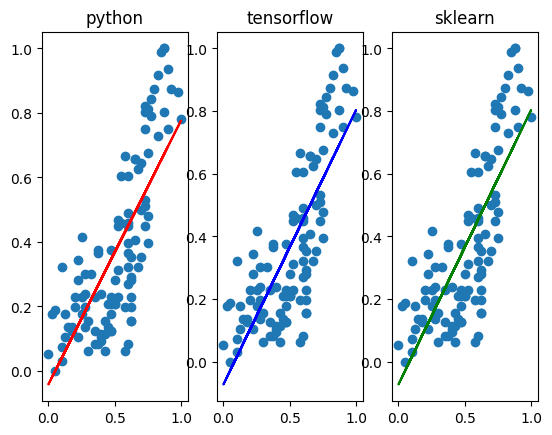

In [16]:
####### 결과를 그래프로 확인해 보아요! #########

fig = plt.figure()

fig_python = fig.add_subplot(1,3,1)
fig_tensorflow = fig.add_subplot(1,3,2)
fig_sklearn = fig.add_subplot(1,3,3)

fig_python.set_title('python')
fig_tensorflow.set_title('tensorflow')
fig_sklearn.set_title('sklearn')

fig_python.scatter(x_data, t_data)
fig_python.plot(x_data, x_data*W.ravel() + b, color='r')

fig_tensorflow.scatter(x_data, t_data)
fig_tensorflow.plot(x_data, x_data*weights + bias, color='b')

fig_sklearn.scatter(x_data, t_data)
fig_sklearn.plot(x_data,
                 x_data*sklearn_model.coef_ + sklearn_model.intercept_,
                 color='g')

In [17]:
# Multiple Linear Regression을 해 보아요!

# 필요한 module import
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

In [19]:
# 데이터 로딩과 전처리!

# Raw Data Loading
df = pd.read_csv('ozone.csv')

training_data = df[['Solar.R', 'Wind', 'Temp', 'Ozone']]

# 이렇게 데이터를 가져온 후 당연히 데이터 전처리를 해야 해요!
# 1. 결측치 처리!
training_data = training_data.dropna(how='any')

# 2. 이상치 처리!
zscore_threshold = 1.8

outlier = training_data['Ozone'][np.abs(stats.zscore(training_data['Ozone'].values)) > zscore_threshold]

# print(outlier)

# 이상치를 제거한 결과를 얻어야 해요!
# 내가 가진 DataFrame에서 이상치를 제거하면 되요!
training_data = training_data.loc[np.isin(training_data['Ozone'],outlier, invert=True)]
# display(training_data)

x_data = training_data.drop('Ozone', axis=1, inplace=False).values
t_data = training_data['Ozone'].values.reshape(-1,1)

# 3. 정규화 진행(Normalization)
#    모든 feature에 대해 scale을 0과 1로 변경!
#    이렇게 해야 해요!
#    프로그램적으로 이 작업을 하려면 코드작업을 해야해서 좀 그래요!
#    sklearn을 이용하면 이 정규화 작업을 아주 쉽게 할 수 있어요!
scaled_x = MinMaxScaler()
scaled_t = MinMaxScaler()

scaled_x.fit(x_data)
scaled_t.fit(t_data)

# 정규화된 Training Data Set 준비
x_data_norm = scaled_x.transform(x_data)
t_data_norm = scaled_t.transform(t_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ozone    116 non-null    float64
 1   Solar.R  146 non-null    float64
 2   Wind     153 non-null    float64
 3   Temp     153 non-null    int64  
 4   Month    153 non-null    int64  
 5   Day      153 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 7.3 KB


In [20]:
# Tensorflow 구현을 해 보아요!

# Model 생성
keras_model = Sequential()

# Flatten은 input layer의 역할을 수행!
# 당연히 입력 feature들을 받아들이는 역할을 수행!
# Flatten안의 동글뱅이(node)는 몇개 있어야 하나요? => 3
keras_model.add(Flatten(input_shape=(3,)))

keras_model.add(Dense(units=1,
                      activation='linear'))

# Model 설정
keras_model.compile(optimizer=SGD(learning_rate=1e-2),
                    loss='mse')

# Model 학습
keras_model.fit(x_data_norm,
                t_data_norm,
                epochs=1000,
                verbose=0)

# Model을 이용한 예측
my_data = np.array([[150.0, 10.0, 80.0]])
scaled_my_data = scaled_x.transform(my_data)

scaled_result = keras_model.predict(scaled_my_data)
result = scaled_t.inverse_transform(scaled_result)

print(f'결과로 알아낸 오존량은 : {result}')  # [[40.26445]]

1/1 [==============================] - 0s 40ms/step
결과로 알아낸 오존량은 : [[39.965565]]


In [26]:
# sklearn 구현

# model 생성
sklearn_model = linear_model.LinearRegression()

# model 학습(정규화하지 않은 데이터를 이용)
sklearn_model.fit(x_data, t_data)

# model로 예측
my_data = np.array([[150.0, 10.0, 80.0]])
# scaled_my_data = scaled_x.transform(my_data)
# scaled_result = sklearn_model.predict(scaled_my_data)
# result = scaled_t.inverse_transform(scaled_result)
result = sklearn_model.predict(my_data)

print(f'결과로 알아낸 오존량은 : {result}')  # T [[40.26445]]
                                             # S [[40.34973385]]


결과로 알아낸 오존량은 : [[40.34973385]]
